# Train experiments

Nota: se instala por terminal databricks y se configura para usar MLflow de databricks community.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

2024-07-26 00:32:53.541358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 00:32:53.806729: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-26 00:32:53.806756: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-26 00:32:55.001953: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
def load_and_preprocess_file(file_path, scaler=None):
    df = pd.read_parquet(file_path)
    data = df.values
    if scaler:
        data = scaler.transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
    return data

def data_generator(file_paths, labels, batch_size, scaler=None):
    while True:
        for start in range(0, len(file_paths), batch_size):
            end = min(start + batch_size, len(file_paths))
            batch_files = file_paths[start:end]
            batch_labels = labels[start:end]
            
            batch_data = [load_and_preprocess_file(f, scaler) for f in batch_files]
            batch_data = np.array(batch_data)
            
            yield batch_data, np.array(batch_labels)

def get_label_for_file(file):
    label = file.split("_")[2]
    label_dict = {
        "prepreictal": 1,
        "preictal": 1,
        "ictal": 0,
        "interictal": 0,
    }
    
    return label_dict[label]

FOLDER = "windows_per_parquet"

print("Reading files")
file_paths = [os.path.join(FOLDER, file) for file in os.listdir(FOLDER) if file.endswith('.parquet')]
labels = [get_label_for_file(file) for file in os.listdir(FOLDER) if file.endswith('.parquet')]

file_paths_train, file_paths_test, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

scaler = StandardScaler()

print("Fit scaler")
sample_data = []
for file_path in file_paths_train:
    sample_data.append(load_and_preprocess_file(file_path))
sample_data = np.array(sample_data).reshape(-1, sample_data[0].shape[-1])
scaler.fit(sample_data)

batch_size = 32

train_gen = data_generator(file_paths_train, y_train, batch_size, scaler)
test_gen = data_generator(file_paths_test, y_test, batch_size, scaler)

steps_per_epoch = len(file_paths_train) // batch_size
validation_steps = len(file_paths_test) // batch_size

In [ ]:
n_classes_train = 4

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(15360, 22)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Regularización L2
        tf.keras.layers.Dense(n_classes_train, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [12]:
model = create_model()

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=test_gen,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=[early_stopping_callback]
)

# Evaluación del modelo
test_loss, test_acc = model.evaluate(test_gen, steps=validation_steps)
print(f'Test accuracy: {test_acc}')


Epoch 1/50
97/97 [==============================] - 52s 464ms/step - loss: 37.1207 - accuracy: 0.2120 - val_loss: 10.8099 - val_accuracy: 0.1315
Epoch 2/50
97/97 [==============================] - 33s 344ms/step - loss: 6.2108 - accuracy: 0.3904 - val_loss: 3.9456 - val_accuracy: 0.2917
Epoch 3/50
97/97 [==============================] - 32s 336ms/step - loss: 1.8257 - accuracy: 0.5416 - val_loss: 5.2251 - val_accuracy: 0.1797
Epoch 4/50
97/97 [==============================] - 32s 333ms/step - loss: 0.9947 - accuracy: 0.6578 - val_loss: 3.8199 - val_accuracy: 0.2448
Epoch 5/50
97/97 [==============================] - 32s 334ms/step - loss: 0.4718 - accuracy: 0.7443 - val_loss: 2.6876 - val_accuracy: 0.5859
Epoch 6/50
97/97 [==============================] - 32s 333ms/step - loss: 0.3825 - accuracy: 0.7755 - val_loss: 2.8097 - val_accuracy: 0.5859
Epoch 7/50
97/97 [==============================] - 31s 324ms/step - loss: 0.2234 - accuracy: 0.8546 - val_loss: 2.6562 - val_accuracy: 0.58

In [ ]:
mlflow.keras.log_model(model, "model")

1/1 [==============================] - 0s 249ms/step


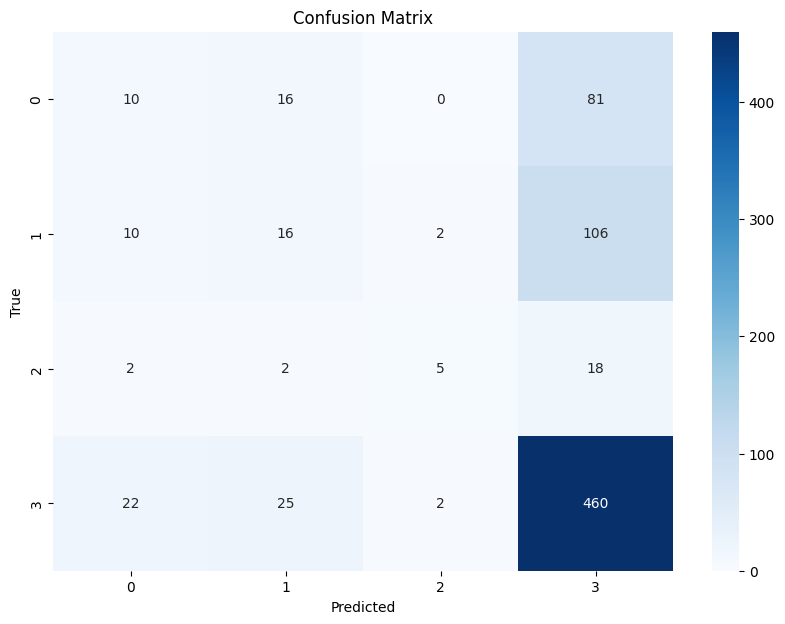

In [129]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = []
y_true = []
filenames_test = []

for i in range(validation_steps+1):
    filenames_test.extend(file_paths_test[batch_size*i:batch_size*(i+1)])
    X_batch, y_batch = next(test_gen)
    y_true.extend(y_batch)
    y_pred_batch = np.argmax(model.predict(X_batch), axis=-1)
    y_pred.extend(y_pred_batch)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("cnn1d/cm_1.jpg")
plt.show()


In [19]:
model.save('modelo_1.h5')

## Métricas

In [27]:
import tensorflow as tf



model = tf.keras.models.load_model('cnn1d/modelo_1.h5')

# Mostrar un resumen del modelo para confirmar que se cargó correctamente
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 15358, 64)         4288      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7679, 64)         0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 491456)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               62906496  
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 62,911,300
Trainable params: 62,911,300
Non-trainable params: 0
__________________________________________

In [6]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Calcular y mostrar el classification report
class_report = classification_report(y_true, y_pred)
print("Classification Report:")
print(class_report)

# Calcular otras métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.09      0.13       107
           1       0.27      0.12      0.17       134
           2       0.56      0.19      0.28        27
           3       0.69      0.90      0.78       509

    accuracy                           0.63       777
   macro avg       0.44      0.33      0.34       777
weighted avg       0.55      0.63      0.57       777

Accuracy: 0.6319
Precision: 0.5505
Recall: 0.6319
F1 Score: 0.5698


In [145]:
import pandas as pd

results_test = pd.DataFrame({"filename": filenames_test})
results_test["y"] = y_true
results_test["y_pred"] = y_pred

results_test["patient"] = results_test["filename"].apply(lambda x: x.split("_")[2].split("/")[-1])

results_test["preictal_true"] = results_test["y"].apply(lambda x: x in (0, 1))
results_test["preictal_pred"] = results_test["y_pred"].apply(lambda x: x in (0, 1))

# there are some chb17a, chb17b, etc. we rename those to chb17
chb_indexes = results_test.query("patient.str.startswith('chb17')").index
results_test.loc[chb_indexes, "patient"] = "chb17"

results_test

,filename,y,y_pred,patient,preictal_true,preictal_pred
0,windows_per_parquet/chb20_29_interictal_2.parquet,1,3,chb20,True,False
1,windows_per_parquet/chb21_18_interictal_2.parquet,0,3,chb21,True,False
2,windows_per_parquet/chb21_28_interictal_0.parquet,3,3,chb21,False,False
3,windows_per_parquet/chb02_20_interictal_4.parquet,2,1,chb02,False,True
4,windows_per_parquet/chb21_19_ictal_0.parquet,1,3,chb21,True,False
...,...,...,...,...,...,...
772,windows_per_parquet/chb24_13_preictal_4.parquet,3,3,chb24,False,False
773,windows_per_parquet/chb15_05_interictal_4.parquet,3,3,chb15,False,False
774,windows_per_parquet/chb20_28_interictal_3.parquet,1,3,chb20,True,False
775,windows_per_parquet/chb03_17_interictal_3.parquet,3,3,chb03,False,False


In [146]:
results_test.preictal_true.value_counts()

preictal_true
False    536
True     241
Name: count, dtype: int64

In [151]:
results_test.patient.value_counts().describe()

count    24.000000
mean     32.375000
std      11.099599
min      13.000000
25%      24.250000
50%      30.500000
75%      41.250000
max      54.000000
Name: count, dtype: float64

In [143]:
from collections import Counter

Counter(y_true_new), Counter(y_pred_new)

(Counter({1: 241, 0: 536}), Counter({0: 674, 1: 103}))

<Axes: xlabel='patient'>

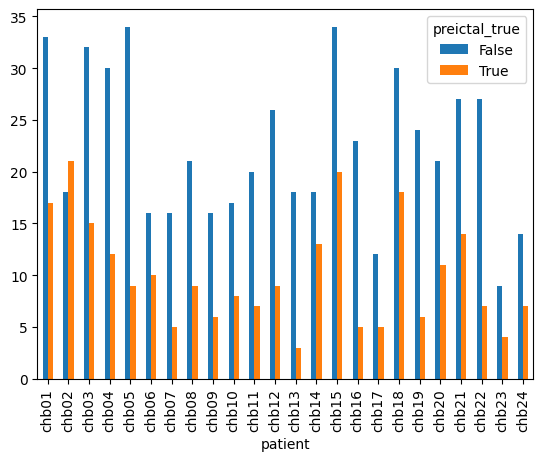

In [152]:
results_test[["patient", "preictal_true"]].value_counts().unstack().plot(kind="bar")

In [153]:
results_test.to_csv("cnn1d/resultados_test_1.csv", index=False)

In [154]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


class_report = classification_report(results_test["preictal_true"], results_test["preictal_pred"])
print("Classification Report:")
print(class_report)

accuracy = accuracy_score(results_test["preictal_true"], results_test["preictal_pred"])
precision = precision_score(results_test["preictal_true"], results_test["preictal_pred"], average='weighted')
recall = recall_score(results_test["preictal_true"], results_test["preictal_pred"], average='weighted')
f1 = f1_score(results_test["preictal_true"], results_test["preictal_pred"], average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

       False       0.72      0.90      0.80       536
        True       0.50      0.22      0.30       241

    accuracy                           0.69       777
   macro avg       0.61      0.56      0.55       777
weighted avg       0.65      0.69      0.65       777

Accuracy: 0.6911
Precision: 0.6530
Recall: 0.6911
F1 Score: 0.6468


In [155]:
recall_score(results_test["preictal_true"], results_test["preictal_pred"])

0.2157676348547718

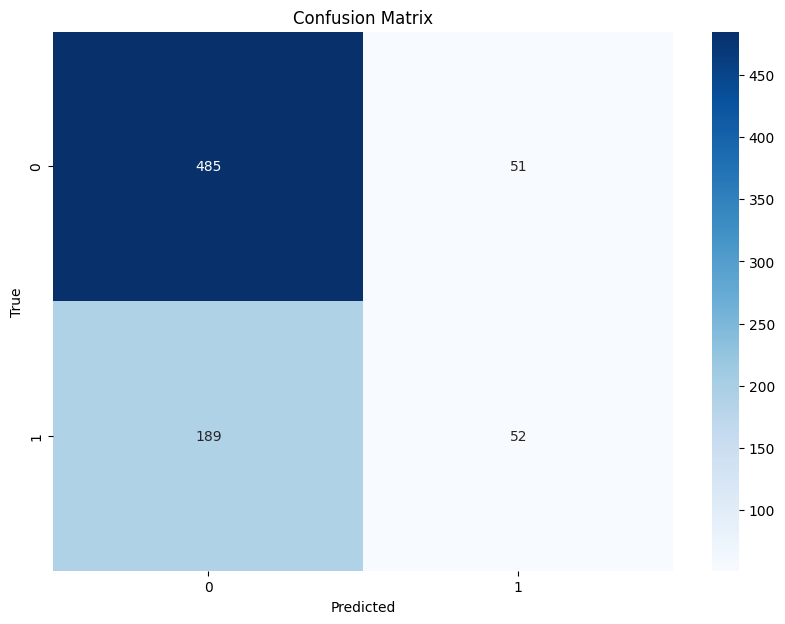

In [160]:
conf_matrix = confusion_matrix(results_test["preictal_true"], results_test["preictal_pred"])

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("cnn1d/cm_bin.jpg")
plt.show()

# Log MLflow

In [ ]:
import mlflow
import mlflow.keras

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/mnsosa@mi.unc.edu.ar/seizure-prediction")

with mlflow.start_run(run_name="nombre_del_run") as run:
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("class_weights", class_weights)
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("n_classes_train", n_classes_train)

    mlflow.log_metric("train_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("val_accuracy", history.history['val_accuracy'][-1])
    mlflow.log_metric("train_loss", history.history['loss'][-1])
    mlflow.log_metric("val_loss", history.history['val_loss'][-1])
    
    mlflow.log_artifact("cnn1d/cm_1.jpg")
    mlflow.log_artifact("cnn1d/cm_bin.jpg")
    

    mlflow.keras.log_model(model, "model")
